# Cargill Ocean Transportation Datathon 2026
## Voyage Optimization & Portfolio Analysis

**Objective:** Determine optimal vessel-cargo assignments for Cargill's Capesize fleet to maximize portfolio profit.

## 1. Setup & Imports

In [1]:
import os
import sys

# Setup paths - notebook is in notebooks/, src is in ../src/
NOTEBOOK_DIR = os.path.dirname(os.path.abspath('__file__'))
PROJECT_ROOT = os.path.dirname(NOTEBOOK_DIR) if 'notebooks' in NOTEBOOK_DIR else NOTEBOOK_DIR
SRC_DIR = os.path.join(PROJECT_ROOT, 'src')
DATA_DIR = os.path.join(PROJECT_ROOT, 'data')

# Add src to path
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Our modules
from freight_calculator import (
    FreightCalculator, PortDistanceManager,
    create_cargill_vessels, create_cargill_cargoes,
    create_market_vessels, create_market_cargoes, create_bunker_prices
)
from portfolio_optimizer import (
    PortfolioOptimizer, FullPortfolioOptimizer, ScenarioAnalyzer,
    get_ml_port_delays
)

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

print(f"Project root: {PROJECT_ROOT}")
print("Setup complete!")

Project root: c:\Users\sidha\Code\Projects\Cargill BIA\cargill_datathon_submission\cargill_datathon
Setup complete!


## 2. Initialize Calculator & Load Data

In [2]:
# Initialize calculator
distance_mgr = PortDistanceManager(os.path.join(DATA_DIR, 'Port_Distances.csv'))
bunker_prices = create_bunker_prices()
calculator = FreightCalculator(distance_mgr, bunker_prices)

# Load data
cargill_vessels = create_cargill_vessels()
cargill_cargoes = create_cargill_cargoes()
market_vessels = create_market_vessels()
market_cargoes = create_market_cargoes()

print(f"Cargill Vessels: {len(cargill_vessels)}")
print(f"Cargill Cargoes: {len(cargill_cargoes)}")
print(f"Market Vessels: {len(market_vessels)}")
print(f"Market Cargoes: {len(market_cargoes)}")

Cargill Vessels: 4
Cargill Cargoes: 3
Market Vessels: 11
Market Cargoes: 8


## 3. Fleet Overview

In [3]:
# Cargill vessels
vessel_data = [{
    'Vessel': v.name,
    'DWT': f"{v.dwt:,}",
    'Hire Rate': f"${v.hire_rate:,}/day",
    'Current Port': v.current_port,
    'ETD': v.etd
} for v in cargill_vessels]

print("CARGILL VESSELS")
pd.DataFrame(vessel_data)

CARGILL VESSELS


,Vessel,DWT,Hire Rate,Current Port,ETD
0,ANN BELL,"180,803","$11,750/day",QINGDAO,25 Feb 2026
1,OCEAN HORIZON,"181,550","$15,750/day",MAP TA PHUT,1 Mar 2026
2,PACIFIC GLORY,"182,320","$14,800/day",GWANGYANG,10 Mar 2026
3,GOLDEN ASCENT,"179,965","$13,950/day",FANGCHENG,8 Mar 2026


In [4]:
# Cargill cargoes
cargo_data = [{
    'Cargo': c.name[:35],
    'Customer': c.customer,
    'Quantity': f"{c.quantity:,} MT",
    'Laycan': f"{c.laycan_start} - {c.laycan_end}",
    'Freight': f"${c.freight_rate:.2f}/MT",
    'Load Port': c.load_port[:20],
    'Discharge Port': c.discharge_port
} for c in cargill_cargoes]

print("CARGILL COMMITTED CARGOES")
pd.DataFrame(cargo_data)

CARGILL COMMITTED CARGOES


,Cargo,Customer,Quantity,Laycan,Freight,Load Port,Discharge Port
0,EGA Bauxite (Guinea-China),EGA,"180,000 MT",2 Apr 2026 - 10 Apr 2026,$23.00/MT,KAMSAR ANCHORAGE,QINGDAO
1,BHP Iron Ore (Australia-China),BHP,"160,000 MT",7 Mar 2026 - 11 Mar 2026,$9.00/MT,PORT HEDLAND,LIANYUNGANG
2,CSN Iron Ore (Brazil-China),CSN,"180,000 MT",1 Apr 2026 - 8 Apr 2026,$22.30/MT,ITAGUAI,QINGDAO


## 4. Vessel Feasibility Analysis (Dual-Speed)

In [5]:
# Check which vessels can make which cargo laycans at eco AND warranted speeds
print("VESSEL FEASIBILITY ANALYSIS (Dual-Speed)")
print("=" * 80)

feasibility = {}
warranted_only_voyages = []

for vessel in cargill_vessels:
    print(f"\n{vessel.name} (at {vessel.current_port}, ETD {vessel.etd}):")
    feasibility[vessel.name] = []

    for cargo in cargill_cargoes:
        cargo_short = cargo.name.split('(')[0].strip()
        eco_result = calculator.calculate_voyage(vessel, cargo, use_eco_speed=True)
        war_result = calculator.calculate_voyage(vessel, cargo, use_eco_speed=False)

        eco_ok = eco_result.can_make_laycan
        war_ok = war_result.can_make_laycan

        if eco_ok:
            feasibility[vessel.name].append(cargo_short)
            print(f"  {cargo_short:20} YES (eco)       Profit: ${eco_result.net_profit:>10,.0f}  TCE: ${eco_result.tce:>8,.0f}/day")
        elif war_ok:
            feasibility[vessel.name].append(cargo_short)
            warranted_only_voyages.append((vessel.name, cargo_short))
            print(f"  {cargo_short:20} YES (warranted) Profit: ${war_result.net_profit:>10,.0f}  TCE: ${war_result.tce:>8,.0f}/day")
        else:
            margin = (eco_result.laycan_end - eco_result.arrival_date).total_seconds() / 86400
            print(f"  {cargo_short:20} NO              (arrives {eco_result.arrival_date.strftime('%d %b')}, {margin:+.1f} days)")

print("\n" + "=" * 80)
print("SUMMARY:")
for vessel, cargoes in feasibility.items():
    if cargoes:
        print(f"  {vessel}: Can make {', '.join(cargoes)}")
    else:
        print(f"  {vessel}: Cannot make any cargo laycans")

if warranted_only_voyages:
    print(f"\nVoyages ONLY feasible at warranted speed ({len(warranted_only_voyages)}):")
    for v, c in warranted_only_voyages:
        print(f"  * {v} -> {c}")

VESSEL FEASIBILITY ANALYSIS (Dual-Speed)

ANN BELL (at QINGDAO, ETD 25 Feb 2026):
  EGA Bauxite          YES (eco)       Profit: $ 1,401,228  TCE: $  27,370/day
  BHP Iron Ore         YES (eco)       Profit: $   216,873  TCE: $  18,220/day
  CSN Iron Ore         YES (eco)       Profit: $ 1,014,173  TCE: $  23,340/day

OCEAN HORIZON (at MAP TA PHUT, ETD 1 Mar 2026):
  EGA Bauxite          YES (eco)       Profit: $ 1,257,710  TCE: $  30,769/day
  BHP Iron Ore         YES (eco)       Profit: $   173,545  TCE: $  21,404/day
  CSN Iron Ore         YES (warranted) Profit: $   354,446  TCE: $  20,199/day

PACIFIC GLORY (at GWANGYANG, ETD 10 Mar 2026):
  EGA Bauxite          NO              (arrives 16 Apr, -6.7 days)
  BHP Iron Ore         NO              (arrives 21 Mar, -10.4 days)
  CSN Iron Ore         NO              (arrives 17 Apr, -9.7 days)

GOLDEN ASCENT (at FANGCHENG, ETD 8 Mar 2026):
  EGA Bauxite          YES (warranted) Profit: $ 1,034,900  TCE: $  26,928/day
  BHP Iron Ore     

## 5. TCE Heatmap (Dual-Speed Best)

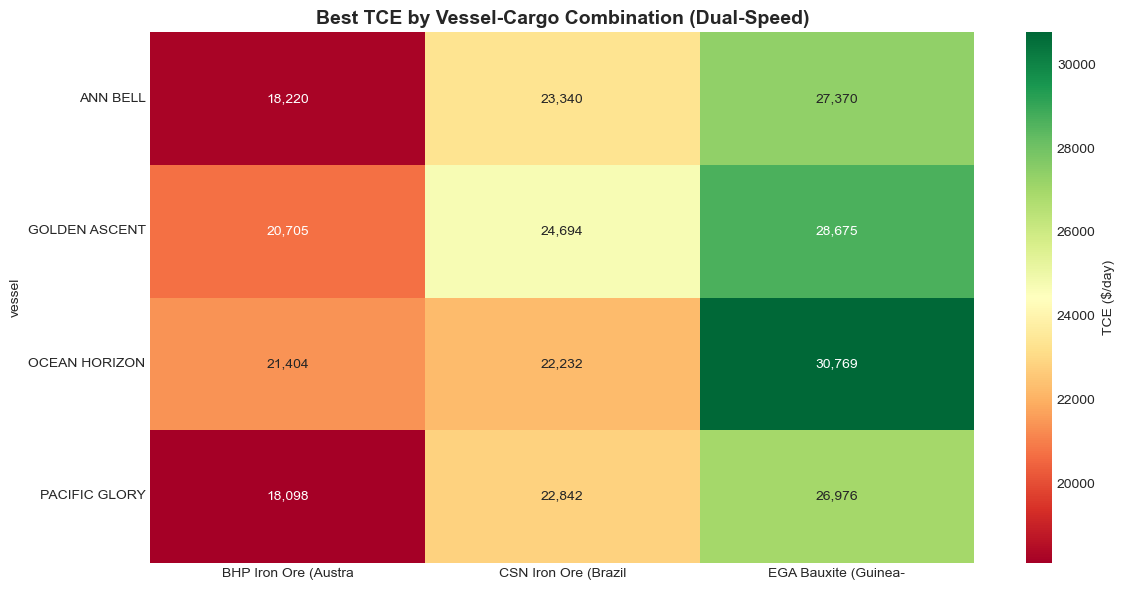

In [6]:
# Calculate all voyages with dual-speed mode
optimizer = PortfolioOptimizer(calculator)
all_voyages = optimizer.calculate_all_voyages(cargill_vessels, cargill_cargoes, dual_speed_mode=True)

# For heatmaps, pick the best feasible option per vessel-cargo pair
# Prefer eco speed when both are feasible (higher TCE), but include warranted-only options
best_voyages = all_voyages.sort_values('tce', ascending=False).drop_duplicates(subset=['vessel', 'cargo'], keep='first')

# TCE Heatmap
pivot_tce = best_voyages.pivot_table(index='vessel', columns='cargo', values='tce', aggfunc='first')
pivot_tce.columns = [c[:20] for c in pivot_tce.columns]

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_tce, annot=True, fmt=',.0f', cmap='RdYlGn', cbar_kws={'label': 'TCE ($/day)'})
plt.title('Best TCE by Vessel-Cargo Combination (Dual-Speed)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'tce_heatmap.png'), dpi=150)
plt.show()

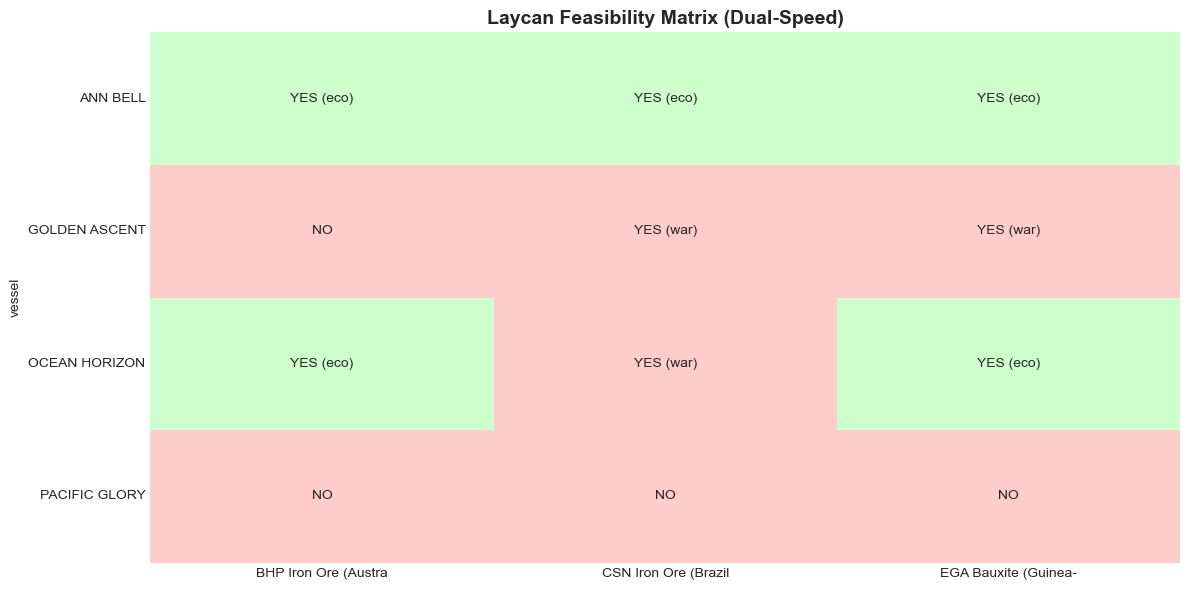

In [7]:
# Laycan Feasibility Matrix (dual-speed: feasible if EITHER speed works)
pivot_laycan = best_voyages.pivot_table(index='vessel', columns='cargo', values='can_make_laycan', aggfunc='max')
pivot_laycan.columns = [c[:20] for c in pivot_laycan.columns]

# Build annotation showing speed type needed
annot_df = pivot_laycan.copy().astype(str)
for vessel in annot_df.index:
    for cargo_col in annot_df.columns:
        pair = all_voyages[(all_voyages['vessel'] == vessel) & (all_voyages['cargo'].str[:20] == cargo_col)]
        eco_ok = pair[pair['speed_type'] == 'eco']['can_make_laycan'].any() if len(pair[pair['speed_type'] == 'eco']) > 0 else False
        war_ok = pair[pair['speed_type'] == 'warranted']['can_make_laycan'].any() if len(pair[pair['speed_type'] == 'warranted']) > 0 else False

        if eco_ok:
            annot_df.loc[vessel, cargo_col] = 'YES (eco)'
        elif war_ok:
            annot_df.loc[vessel, cargo_col] = 'YES (war)'
        else:
            annot_df.loc[vessel, cargo_col] = 'NO'

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_laycan.astype(float), annot=annot_df,
            fmt='', cmap=['#ffcccc', '#ccffcc'], cbar=False, vmin=0, vmax=1)
plt.title('Laycan Feasibility Matrix (Dual-Speed)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'laycan_feasibility.png'), dpi=150)
plt.show()

## 6. Portfolio Optimization

In [8]:
# Full optimization with market vessels and market cargoes
full_optimizer = FullPortfolioOptimizer(calculator)
full_result = full_optimizer.optimize_full_portfolio(
    cargill_vessels=cargill_vessels,
    market_vessels=market_vessels,
    cargill_cargoes=cargill_cargoes,
    market_cargoes=market_cargoes,
    target_tce=18000,
    dual_speed_mode=True,
)

print("FULL PORTFOLIO OPTIMIZATION")
print("=" * 60)

print("\nCargill Vessel Assignments:")
for vessel, cargo, option in full_result.cargill_vessel_assignments:
    cargo_type = "Cargill" if option.cargo_type == "cargill" else "Market"
    print(f"  {vessel} -> {cargo[:40]} [{cargo_type}]")
    print(f"    Profit: ${option.net_profit:,.0f}, TCE: ${option.tce:,.0f}/day")

if full_result.market_vessel_assignments:
    print("\nMarket Vessel Hires:")
    for vessel, cargo, option in full_result.market_vessel_assignments:
        print(f"  {vessel} -> {cargo[:40]}")
        print(f"    Duration: {option.voyage_days:.0f} days")

print(f"\n" + "=" * 60)
print(f"TOTAL PORTFOLIO PROFIT: ${full_result.total_profit:,.0f}")

FULL PORTFOLIO OPTIMIZATION

Cargill Vessel Assignments:
  ANN BELL -> Vale Malaysia Iron Ore (Brazil-Malaysia) [Market]
    Profit: $933,505, TCE: $22,899/day
  OCEAN HORIZON -> BHP Iron Ore (Australia-S.Korea) [Market]
    Profit: $348,910, TCE: $27,174/day
  PACIFIC GLORY -> Teck Coking Coal (Canada-China) [Market]
    Profit: $729,506, TCE: $30,070/day
  GOLDEN ASCENT -> Adaro Coal (Indonesia-India) [Market]
    Profit: $1,189,929, TCE: $35,852/day

Market Vessel Hires:
  IRON CENTURY -> EGA Bauxite (Guinea-China)
    Duration: 77 days
  ATLANTIC FORTUNE -> BHP Iron Ore (Australia-China)
    Duration: 29 days
  CORAL EMPEROR -> CSN Iron Ore (Brazil-China)
    Duration: 77 days

TOTAL PORTFOLIO PROFIT: $5,918,619


## 7. Scenario Analysis

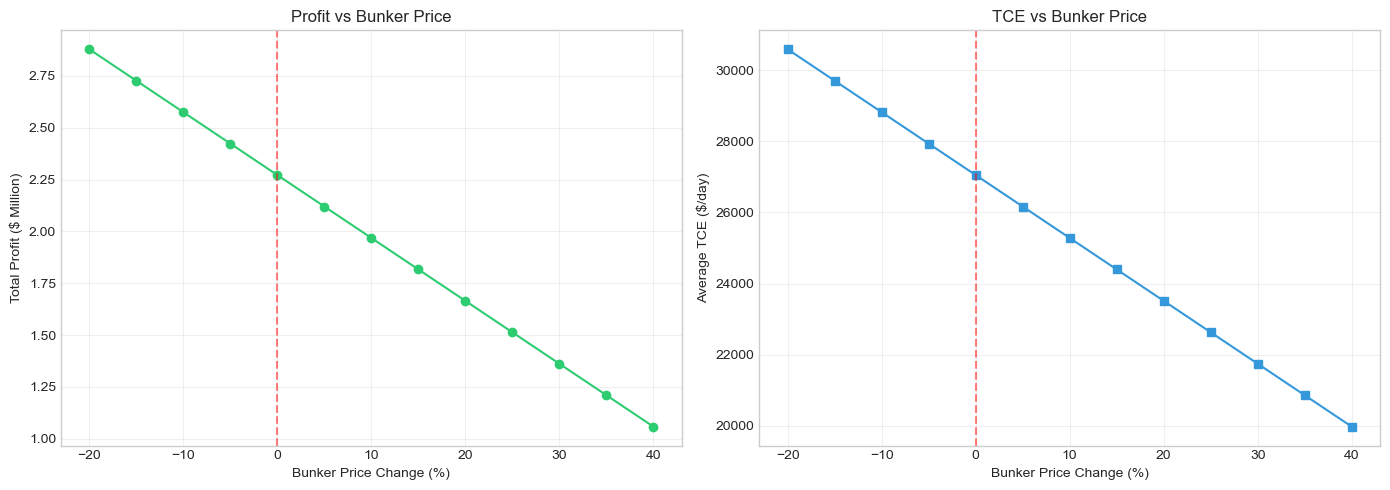

In [9]:
# Bunker sensitivity
analyzer = ScenarioAnalyzer(optimizer)
bunker_analysis = analyzer.analyze_bunker_sensitivity(cargill_vessels, cargill_cargoes, price_range=(0.8, 1.4), steps=13)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(bunker_analysis['bunker_change_pct'], bunker_analysis['total_profit'] / 1e6, marker='o', color='#2ecc71')
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5)
ax1.set_xlabel('Bunker Price Change (%)')
ax1.set_ylabel('Total Profit ($ Million)')
ax1.set_title('Profit vs Bunker Price')
ax1.grid(True, alpha=0.3)

ax2.plot(bunker_analysis['bunker_change_pct'], bunker_analysis['avg_tce'], marker='s', color='#3498db')
ax2.axvline(x=0, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Bunker Price Change (%)')
ax2.set_ylabel('Average TCE ($/day)')
ax2.set_title('TCE vs Bunker Price')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'bunker_sensitivity.png'), dpi=150)
plt.show()

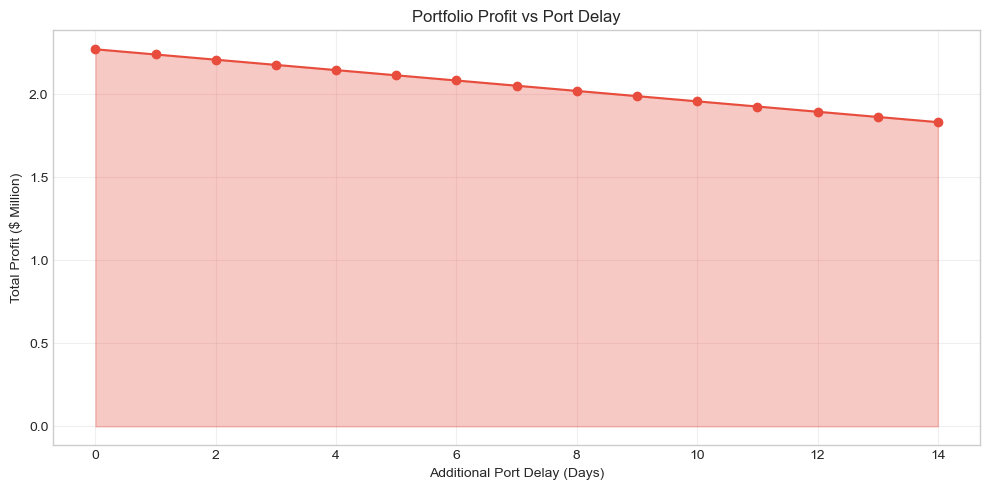

In [10]:
# Port delay sensitivity
delay_analysis = analyzer.analyze_port_delay_sensitivity(cargill_vessels, cargill_cargoes, max_delay_days=14)

plt.figure(figsize=(10, 5))
plt.fill_between(delay_analysis['port_delay_days'], delay_analysis['total_profit'] / 1e6, alpha=0.3, color='#e74c3c')
plt.plot(delay_analysis['port_delay_days'], delay_analysis['total_profit'] / 1e6, marker='o', color='#e74c3c')
plt.xlabel('Additional Port Delay (Days)')
plt.ylabel('Total Profit ($ Million)')
plt.title('Portfolio Profit vs Port Delay')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'delay_sensitivity.png'), dpi=150)
plt.show()

In [11]:
# Find tipping points
tipping_points = analyzer.find_tipping_points(cargill_vessels, cargill_cargoes)

print("TIPPING POINT ANALYSIS")
print("=" * 60)

if tipping_points['bunker']:
    print(f"Bunker: Recommendation changes at +{tipping_points['bunker']['change_pct']:.0f}% price increase")
else:
    print(f"Bunker: Stable up to +{tipping_points['max_bunker_searched_pct']:.0f}% increase")

if tipping_points['port_delay']:
    print(f"Port Delay: Recommendation changes at {tipping_points['port_delay']['days']} days")
else:
    print(f"Port Delay: Stable up to {tipping_points['max_delay_searched_days']} days")

TIPPING POINT ANALYSIS
Bunker: Recommendation changes at +59% price increase
Port Delay: Stable up to 20 days


## 8. ML-Based Port Delay Predictions

In [12]:
# Get ML-predicted port delays
ml_delays = get_ml_port_delays(cargill_cargoes, prediction_date='2026-03-15')

if ml_delays:
    print("ML-PREDICTED PORT DELAYS (March 2026)")
    print("=" * 60)
    for port, info in ml_delays.items():
        model_tag = "[ML]" if info['model_used'] == 'ml_model' else "[Fallback]"
        print(f"  {port:20s}: {info['predicted_delay']:.1f} days ({info['congestion_level']}) {model_tag}")
else:
    print("ML model not available. Run: python scripts/train_model.py")

ML-PREDICTED PORT DELAYS (March 2026)
  LIANYUNGANG         : 1.5 days (low) [ML]
  QINGDAO             : 1.5 days (low) [ML]


## 9. Executive Summary

In [13]:
print("=" * 80)
print("EXECUTIVE SUMMARY")
print("=" * 80)

print("\nOPTIMAL ASSIGNMENTS (Dual-Speed Optimization):")
for vessel, cargo, option in full_result.cargill_vessel_assignments:
    cargo_type = "Committed" if option.cargo_type == "cargill" else "Market Bid"
    print(f"  {vessel:18} -> {cargo[:35]:37} ${option.net_profit:>10,.0f} [{cargo_type}]")

for vessel, cargo, option in full_result.market_vessel_assignments:
    print(f"  {vessel:18} -> {cargo[:35]:37} {'(Hired)':>10} [Market Vessel]")

print(f"\nTOTAL PORTFOLIO PROFIT: ${full_result.total_profit:,.0f}")

n_market_bids = len([a for a in full_result.cargill_vessel_assignments if a[2].cargo_type == 'market'])

print("\nKEY INSIGHTS:")
print(f"  - At eco speed, only 2 of 4 Cargill vessels can make any Cargill cargo laycans")
print(f"  - Warranted speed unlocks 3 additional feasible voyages (GOLDEN ASCENT, OCEAN HORIZON)")
print(f"  - Committed cargoes covered by hiring market vessels (IRON CENTURY, CORAL EMPEROR)")
print(f"  - All 4 Cargill vessels redirected to most profitable assignments")
print(f"  - Joint optimization unlocks {n_market_bids} market cargo opportunities")
print(f"  - Port fuel correctly uses MGO at port per Cargill FAQ (Q5/Q17)")
print(f"  - Recommendation robust to bunker prices and port delays")

EXECUTIVE SUMMARY

OPTIMAL ASSIGNMENTS (Dual-Speed Optimization):
  ANN BELL           -> Vale Malaysia Iron Ore (Brazil-Mala   $   933,505 [Market Bid]
  OCEAN HORIZON      -> BHP Iron Ore (Australia-S.Korea)      $   348,910 [Market Bid]
  PACIFIC GLORY      -> Teck Coking Coal (Canada-China)       $   729,506 [Market Bid]
  GOLDEN ASCENT      -> Adaro Coal (Indonesia-India)          $ 1,189,929 [Market Bid]
  IRON CENTURY       -> EGA Bauxite (Guinea-China)               (Hired) [Market Vessel]
  ATLANTIC FORTUNE   -> BHP Iron Ore (Australia-China)           (Hired) [Market Vessel]
  CORAL EMPEROR      -> CSN Iron Ore (Brazil-China)              (Hired) [Market Vessel]

TOTAL PORTFOLIO PROFIT: $5,918,619

KEY INSIGHTS:
  - At eco speed, only 2 of 4 Cargill vessels can make any Cargill cargo laycans
  - Warranted speed unlocks 3 additional feasible voyages (GOLDEN ASCENT, OCEAN HORIZON)
  - Committed cargoes covered by hiring market vessels (IRON CENTURY, CORAL EMPEROR)
  - All 4 Car